In [1]:
# 🔧 Setup: Add project root to Python path

import sys
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
# 📦 Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# MAPP package imports
from mapp.data.simulate_auction_data import simulate_experiment_data
from mapp.methods.cdf_based.rde_trainer import train_rde_model
from mapp.methods.myerson_net_trainer import train_myerson_net_model
from mapp.experiments.run_experiments import run_experiments
from mapp.utils.plot import plot_kfold_sensitivity, plot_regret_histograms

print("✅ MAPP package loaded successfully")

✅ MAPP package loaded successfully


# Real Data Analysis: FCC AWS-3 Spectrum Auction

This notebook analyzes real auction data from the FCC AWS-3 spectrum auction (Auction 97).

**Workflow Steps:**
1. Load and preprocess real auction data
2. Analyze bid distributions by spectrum block
3. Generate training and test datasets from real data
4. Train RDE and MyersonNet models on real auction patterns
5. Compare pricing methods on real data
6. Visualize results

**Data Source:** FCC Auction 97 (AWS-3)
- Multiple spectrum blocks (A1, B1, G, H, I, J)
- Real bidder behavior across multiple rounds
- Highly heterogeneous value distributions

**Pricing Methods Tested:**
- **eCDF**: Empirical CDF from observed bids
- **KDE**: Kernel Density Estimation
- **RDE**: Repeated Density Estimation (FPCA-based, requires training)
- **Myerson**: Myerson auction mechanism (convex hull method)
- **MyersonNet**: Neural network-based optimal auction mechanism

## Step 1: Load and Preprocess Real Auction Data

Load FCC AWS-3 auction data and explore the bid distributions across different spectrum blocks.

In [3]:
# Load auction data
df = pd.read_csv("../mapp/data/auction97.csv")
print(f"📊 Loaded {len(df):,} auction records")
df.head()

/var/folders/yh/wjjhzwhx54b5t1_q6yd628240000gn/T/ipykernel_9251/1538453009.py:2: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../mapp/data/auction97.csv")


📊 Loaded 1,201,048 auction records


,Unnamed: 0,auction_id,auction_description,round,item_name,item_description,bidder_name,bidder_frn,market,block,...,solver_optimum_percentage,solver_options,price_weight,previous_pw_bidder,previous_pw_bidder_frn,round_of_previous_pwb,round_of_withdrawal,round_withdrawn_pwb_placed,withdrawn_pwb_amount,withdrawn_net_pwb_amount
0,0,97,AWS-3,1.0,AW-BEA001-H,Bangor ME,T-Mobile License LLC,1565449.0,BEA001,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,97,AWS-3,1.0,AW-BEA002-H,Portland ME,T-Mobile License LLC,1565449.0,BEA002,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,97,AWS-3,1.0,AW-BEA002-J,Portland ME,AT&T Wireless Services 3 LLC,23910920.0,BEA002,J,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,97,AWS-3,1.0,AW-BEA003-B1,Boston-Worcester MA-NH-RI-VT,2014 AWS Spectrum Bidco Corporation,23933575.0,BEA003,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,97,AWS-3,1.0,AW-BEA003-H,Boston-Worcester MA-NH-RI-VT,"Northstar Wireless, LLC",23917453.0,BEA003,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Extract relevant columns
useful_df = df[["round", "item_name", "block", "bidder_name", "bid_amount"]].dropna()
print(f"📊 {len(useful_df):,} valid bid records")
useful_df.head()

📊 41,609 valid bid records


,round,item_name,block,bidder_name,bid_amount
0,1.0,AW-BEA001-H,H,T-Mobile License LLC,43000.0
1,1.0,AW-BEA002-H,H,T-Mobile License LLC,387000.0
2,1.0,AW-BEA002-J,J,AT&T Wireless Services 3 LLC,775000.0
3,1.0,AW-BEA003-B1,B1,2014 AWS Spectrum Bidco Corporation,4539000.0
4,1.0,AW-BEA003-H,H,"Northstar Wireless, LLC",13616000.0


For each (item, bidder) pair, keep only the last bid (highest round number). This represents each bidder's final valuation for each item.

In [5]:
# Keep only the last bid for each (item, bidder) pair
clean_df = (
    useful_df.sort_values("round", ascending=False)
    .groupby(["item_name", "bidder_name"])
    .first()
    .reset_index()
)

print(f"📊 {len(clean_df):,} unique (item, bidder) bids")
print("\nBids per spectrum block:")
print(clean_df.groupby("block")["bid_amount"].count())
clean_df.head()

📊 8,897 unique (item, bidder) bids

Bids per spectrum block:
block
A1     679
B1     846
G     4286
H     1126
I     1037
J      923
Name: bid_amount, dtype: int64


,item_name,bidder_name,round,block,bid_amount
0,AW-BEA001-A1,American AWS-3 Wireless I L.L.C.,19.0,A1,9800.0
1,AW-BEA001-A1,"Northstar Wireless, LLC",255.0,A1,36000.0
2,AW-BEA001-A1,"SNR Wireless LicenseCo, LLC",255.0,A1,36000.0
3,AW-BEA001-A1,"Sofio, Joseph A",254.0,A1,31000.0
4,AW-BEA001-B1,2014 AWS Spectrum Bidco Corporation,39.0,B1,71000.0


## Step 2: Analyze Bid Distributions by Spectrum Block

Visualize raw bid distributions across spectrum blocks.

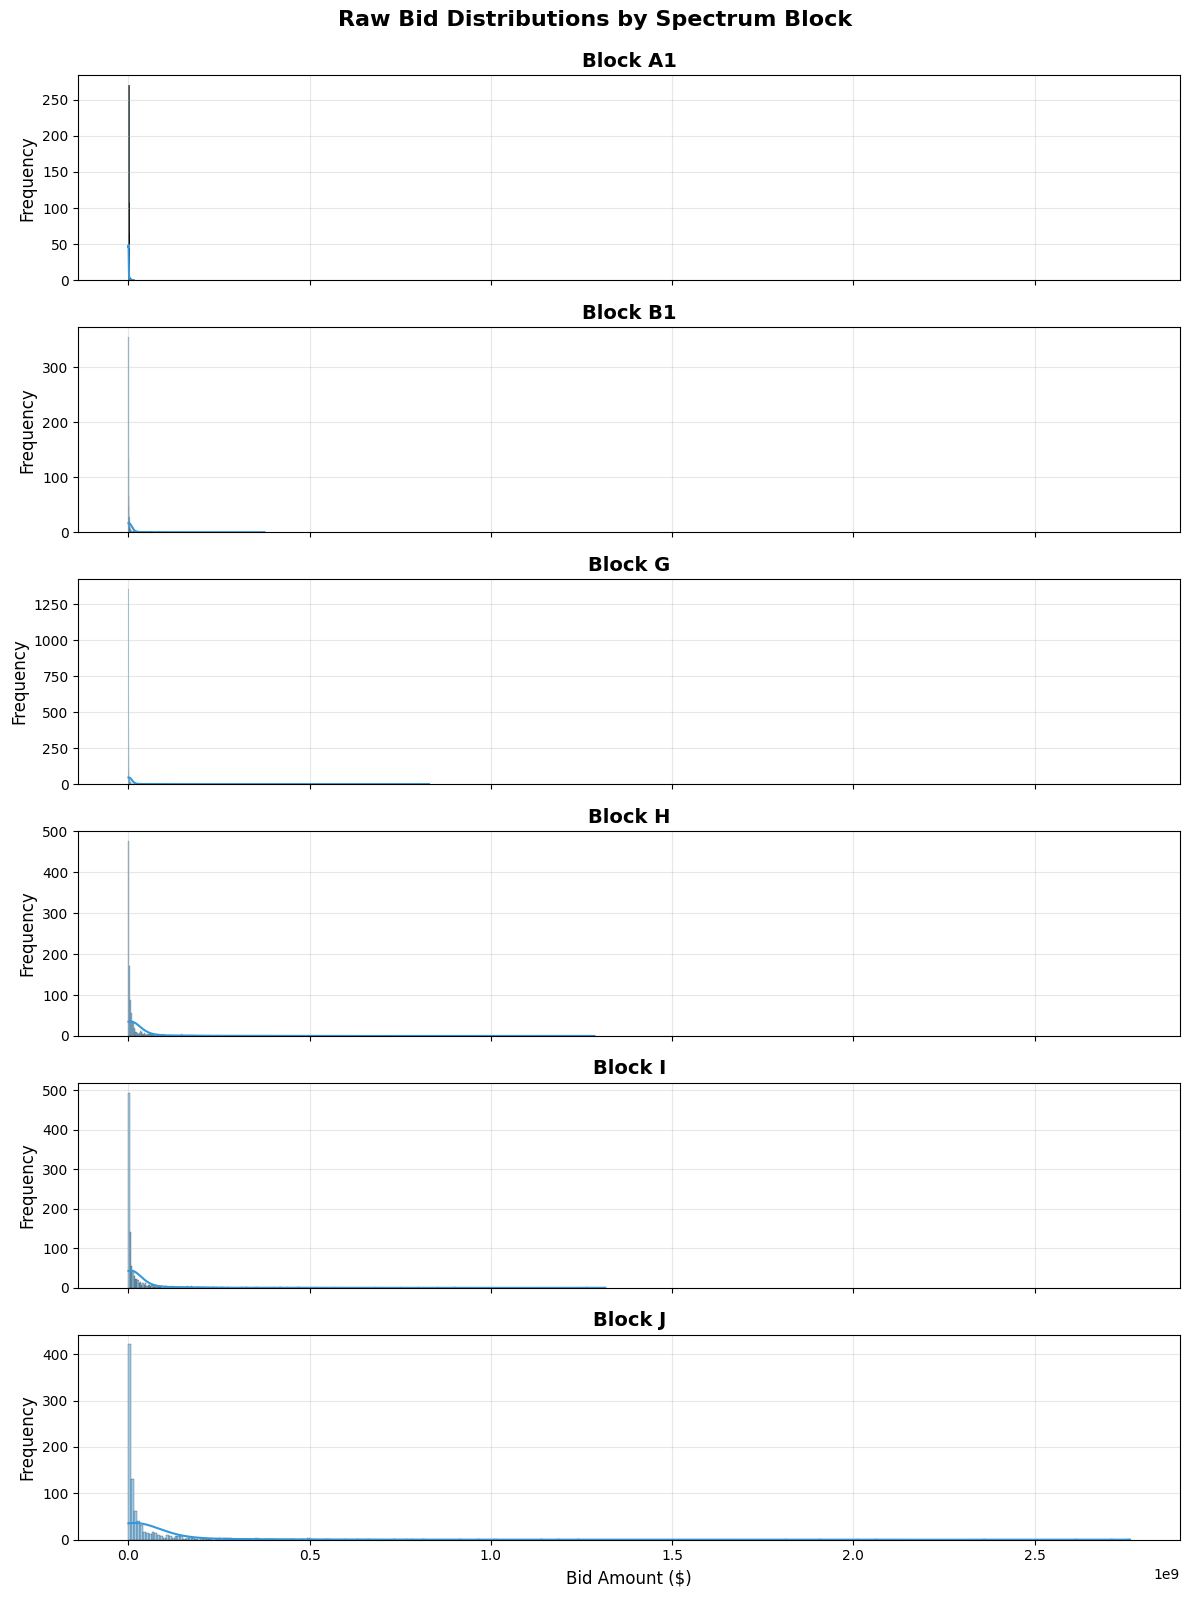

In [6]:
# Plot raw bid distributions by block
data = clean_df[["block", "bidder_name", "bid_amount"]].groupby("block")

fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

for (block, group), ax in zip(data, axes):
    sns.histplot(data=group, x="bid_amount", kde=True, ax=ax, color="#3498DB")
    ax.set_title(f"Block {block}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Bid Amount ($)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    "Raw Bid Distributions by Spectrum Block", fontsize=16, fontweight="bold", y=0.995
)
plt.tight_layout()
plt.show()

Apply log transformation to handle the wide range of bid values, then normalize to [1, 10] range to match simulated data.

In [7]:
# Log transform
clean_df["log_bid"] = clean_df["bid_amount"].transform(np.log)
log_data = clean_df[["block", "bidder_name", "log_bid"]].groupby("block")

# Check log-transformed ranges
print("Log-transformed bid ranges by block:")
print(log_data["log_bid"].agg(["min", "max", "mean", "std"]).round(2))

Log-transformed bid ranges by block:
         min    max   mean   std
block                           
A1      7.24  16.54  12.18  1.73
B1      7.60  19.74  13.55  2.04
G       6.91  20.54  13.32  2.08
H       9.62  20.97  15.20  2.00
I       9.95  21.00  15.27  2.09
J      10.76  21.74  16.20  2.03


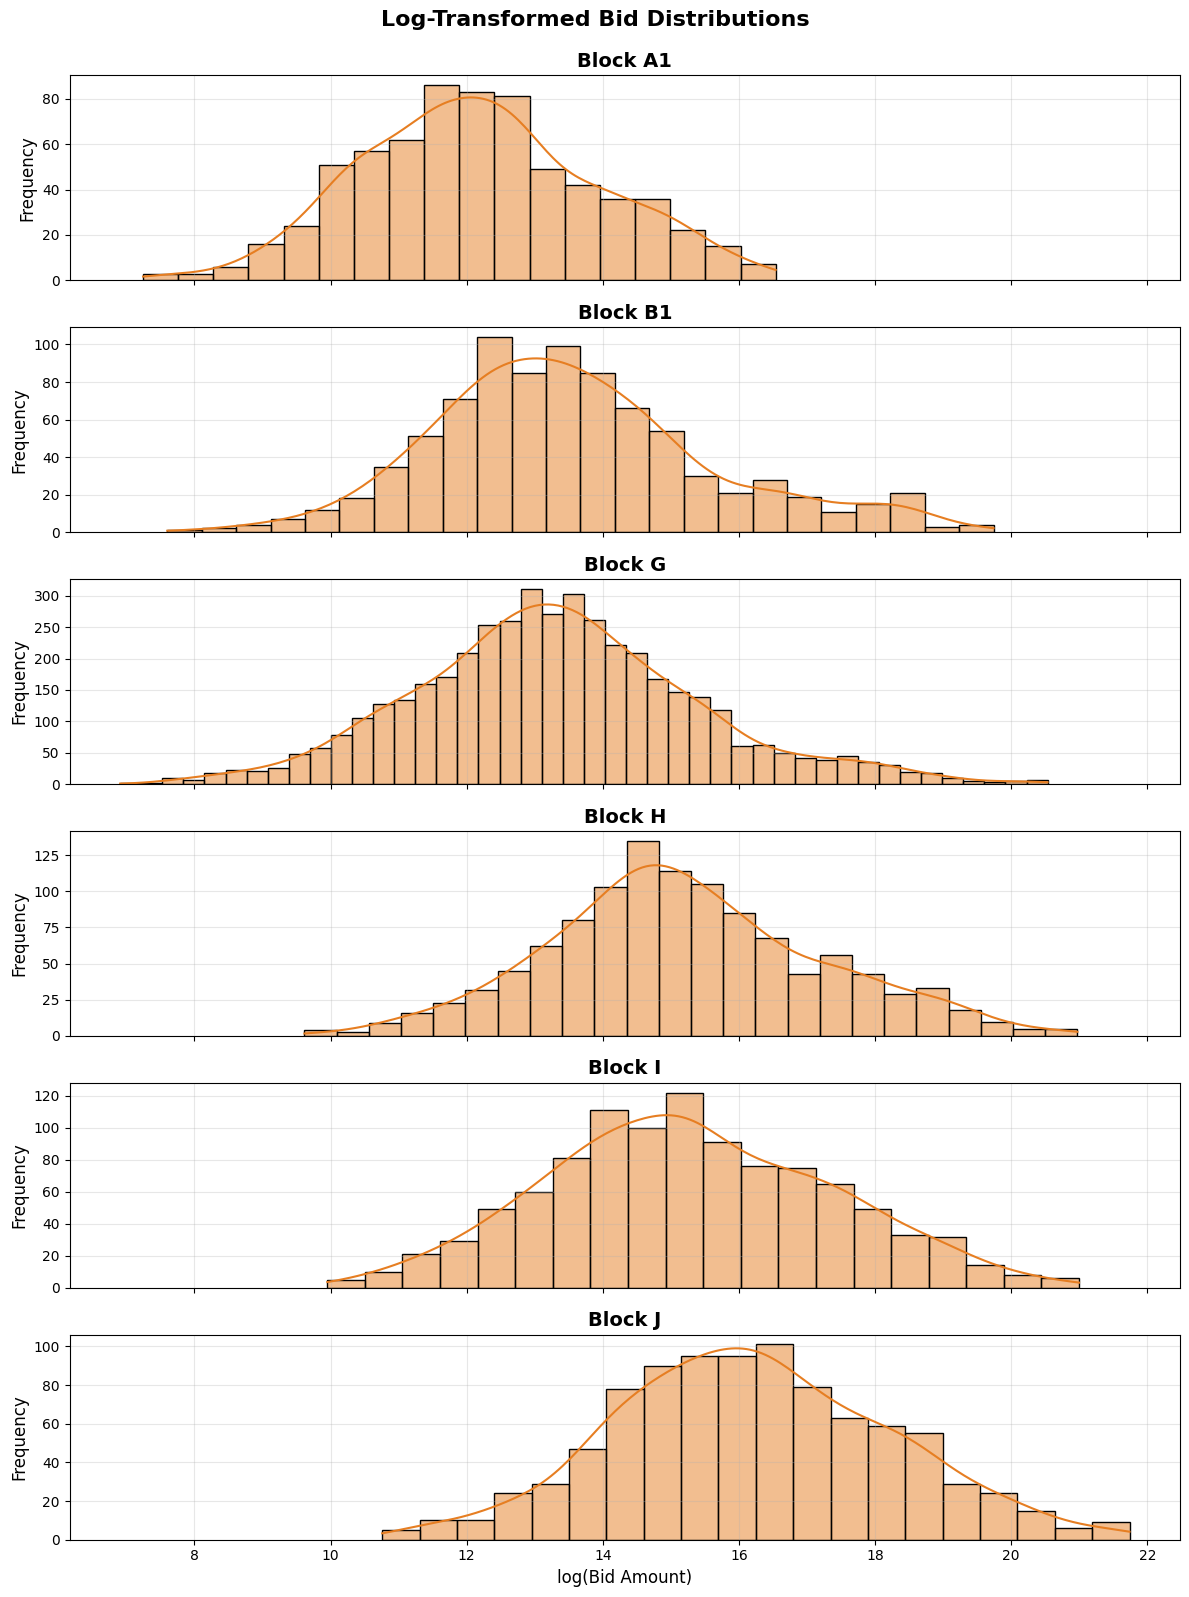

In [8]:
# Plot log-transformed distributions
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True)

for (block, group), ax in zip(log_data, axes):
    sns.histplot(data=group, x="log_bid", kde=True, ax=ax, color="#E67E22")
    ax.set_title(f"Block {block}", fontsize=14, fontweight="bold")
    ax.set_xlabel("log(Bid Amount)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, alpha=0.3)

plt.suptitle(
    "Log-Transformed Bid Distributions", fontsize=16, fontweight="bold", y=0.995
)
plt.tight_layout()
plt.show()

In [9]:
# Normalize to [1, 10] range (matching simulated data bounds)
target_min, target_max = 1.0, 10.0

clean_df["scaled_log_bid"] = clean_df.groupby("block")["log_bid"].transform(
    lambda x: target_min
    + ((x - x.min()) / (x.max() - x.min())) * (target_max - target_min)
)

scaled_log_data = clean_df[["block", "bidder_name", "scaled_log_bid"]].groupby("block")

print("Normalized bid statistics by block:")
print(scaled_log_data["scaled_log_bid"].agg(["min", "max", "mean", "std"]).round(2))

Normalized bid statistics by block:
       min   max  mean   std
block                       
A1     1.0  10.0  5.77  1.67
B1     1.0  10.0  5.41  1.51
G      1.0  10.0  5.24  1.38
H      1.0  10.0  5.43  1.58
I      1.0  10.0  5.34  1.71
J      1.0  10.0  5.46  1.67


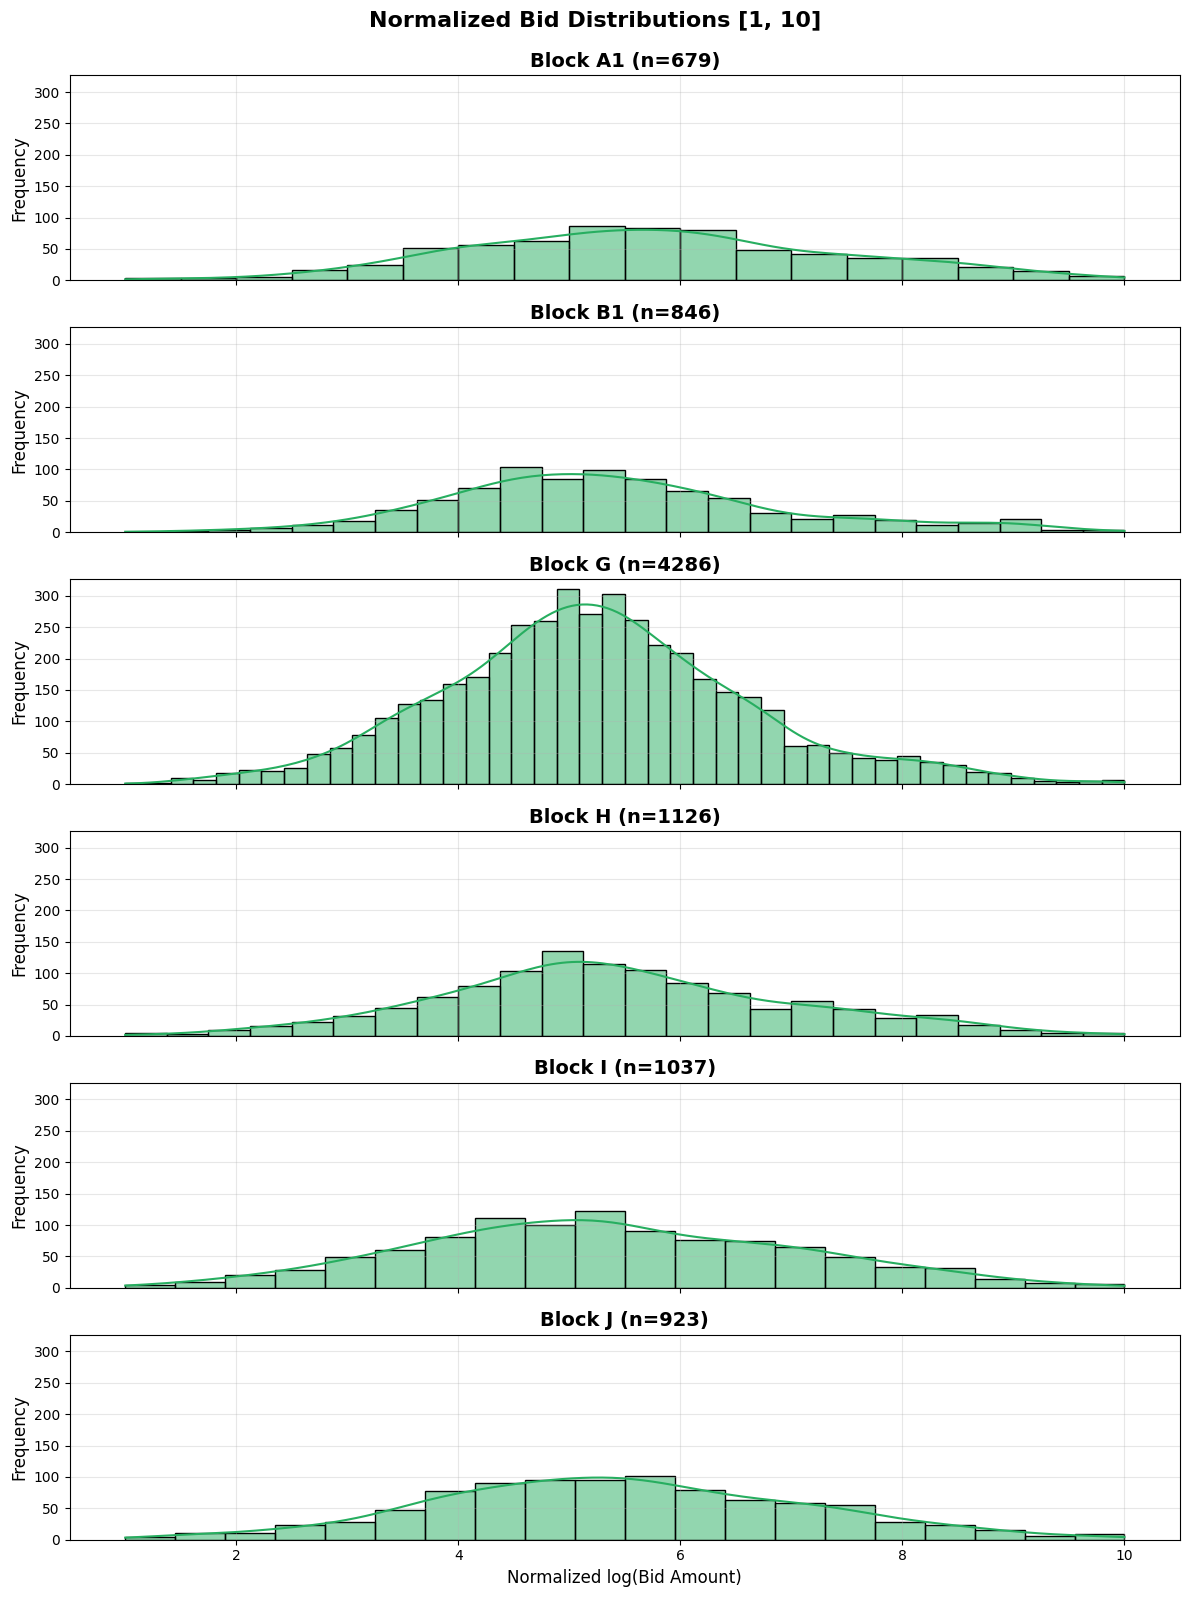

In [10]:
# Plot normalized distributions
fig, axes = plt.subplots(6, 1, figsize=(12, 16), sharex=True, sharey=True)

for (block, group), ax in zip(scaled_log_data, axes):
    sns.histplot(data=group, x="scaled_log_bid", kde=True, ax=ax, color="#27AE60")
    ax.set_title(f"Block {block} (n={len(group)})", fontsize=14, fontweight="bold")
    ax.set_xlabel("Normalized log(Bid Amount)", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.5, 10.5)

plt.suptitle(
    "Normalized Bid Distributions [1, 10]", fontsize=16, fontweight="bold", y=0.995
)
plt.tight_layout()
plt.show()

Overlay all spectrum block distributions to confirm from the same distribution family.

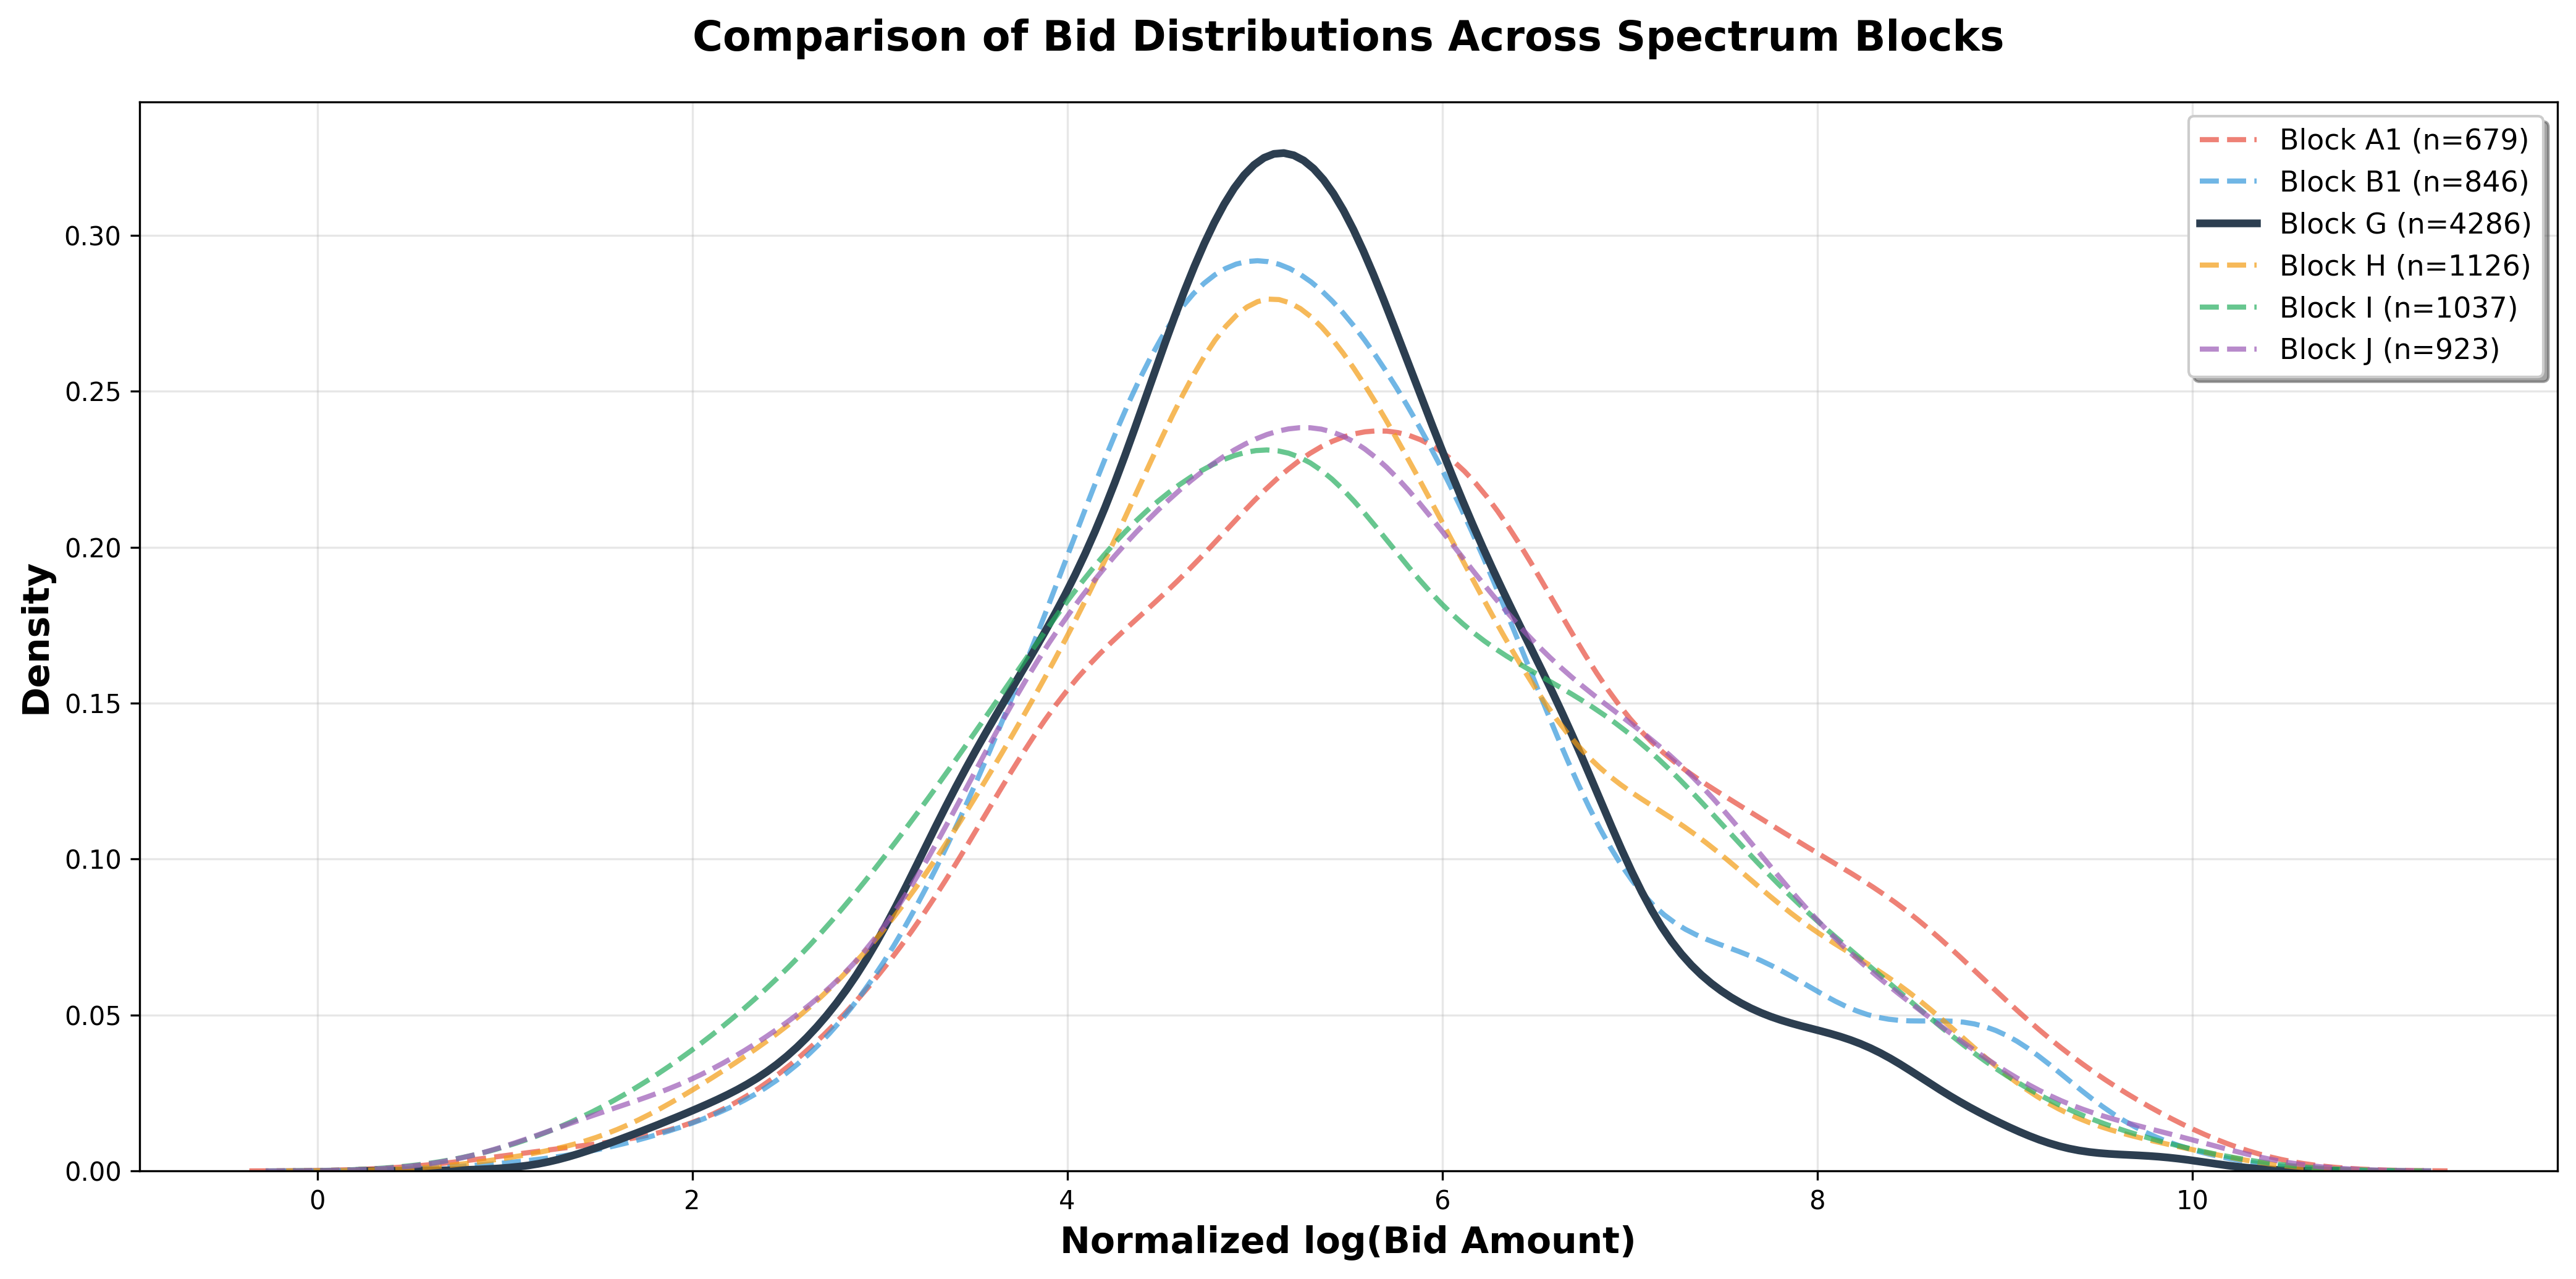

📊 Block G selected as test distribution (largest sample size)


In [11]:
# Overlay all block distributions
plt.figure(figsize=(14, 7), dpi=300)

colors = {
    "A1": "#E74C3C",
    "B1": "#3498DB",
    "G": "#2C3E50",
    "H": "#F39C12",
    "I": "#27AE60",
    "J": "#9B59B6",
}

for block, group in scaled_log_data:
    block_str = str(block)  # Convert to string for type safety
    if block == "G":
        # Emphasize Block G (test distribution)
        sns.kdeplot(
            data=group,
            x="scaled_log_bid",
            label=f"Block {block_str} (n={len(group)})",
            color=colors[block_str],
            linewidth=3,
        )
    else:
        sns.kdeplot(
            data=group,
            x="scaled_log_bid",
            label=f"Block {block_str} (n={len(group)})",
            color=colors[block_str],
            linestyle="--",
            linewidth=2,
            alpha=0.7,
        )

plt.xlabel("Normalized log(Bid Amount)", fontsize=14, fontweight="bold")
plt.ylabel("Density", fontsize=14, fontweight="bold")
plt.title(
    "Comparison of Bid Distributions Across Spectrum Blocks",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
plt.legend(fontsize=11, loc="upper right", frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Block G selected as test distribution (largest sample size)")

## Step 3: Generate Training and Test Datasets from Real Data

In [12]:
# 📊 Experiment Configuration
# Test data configuration
N_RUNS = 1000
N_AUCTIONS = 200
BIDS_PER_AUCTION = [10, 50, 100, 200]
TEST_SEED = 0
K_FOLDS = [2, 5, 10]


# RDE training configurations
RDE_CONFIGS = [(200, 20), (20, 200), (200, 200)]  # (N_train, n_train)

# MyersonNet training configurations
# Train models for ALL unique group sizes (perfect match, no truncation/padding)
MYERSONNET_CONFIGS = [
    (200, 200, 2),  # Groups of 2: 10 bids/k=5 → 20,000 samples
    (200, 200, 5),  # Groups of 5: 10/k=2, 50/k=10 → 8,000 samples
    (200, 200, 10),  # Groups of 10: 50/k=5, 100/k=10 → 4,000 samples
    (200, 200, 20),  # Groups of 20: 100/k=5, 200/k=10 → 2,000 samples
    (200, 200, 25),  # Groups of 25: 50/k=2 → 1,600 samples
    (200, 200, 40),  # Groups of 40: 200/k=5 → 1,000 samples
    (200, 200, 50),  # Groups of 50: 100/k=2 → 800 samples
    (200, 200, 100),  # Groups of 100: 200/k=2 → 400 samples
]
MYERSONNET_EPOCHS = 50000  # Training epochs for MyersonNet

# Determine training data requirements
TRAIN_AUCTIONS = max(
    max(N for N, n in RDE_CONFIGS), max(N for N, n, _ in MYERSONNET_CONFIGS)
)
TRAIN_BIDS_PER_AUCTION = max(
    max(n for N, n in RDE_CONFIGS), max(n for N, n, _ in MYERSONNET_CONFIGS)
)
TRAIN_SEED = 9999

total_configs = len(BIDS_PER_AUCTION) * len(K_FOLDS)

print(
    f"📊 {len(BIDS_PER_AUCTION)} bids × {len(K_FOLDS)} K = {len(BIDS_PER_AUCTION)*len(K_FOLDS)} experiments"
)

📊 4 bids × 3 K = 12 experiments


**Data Generated:**
- ✅ Test data: 1000 runs × 200 auctions × 200 bids
  - Source: Block G (single source, largest sample)
  - Method: Bootstrap with KDE CDF estimation
  - Cached at: `workspace/real/data/real_a200_b200_r1000_s0_test.json`

- ✅ Training data: 1 run × 200 auctions × 200 bids
  - Sources: Blocks A1, B1, H, I, J (mixed sources)
  - Method: Each auction randomly selects a block, then bootstraps
  - Used for: RDE and MyersonNet model training
  - Cached at: `workspace/real/data/real_a200_b200_s9999_train.json`

In [13]:
# Extract all blocks
block_bids = {
    block: np.asarray(group["scaled_log_bid"]) for block, group in scaled_log_data
}
print(
    f"✅ {len(block_bids)} blocks: {', '.join(f'{b}({len(v)})' for b, v in block_bids.items())}"
)

✅ 6 blocks: A1(679), B1(846), G(4286), H(1126), I(1037), J(923)


In [14]:
# Generate test data using simulate_experiment_data
test_data = simulate_experiment_data(
    dist_name="real",
    purpose="test",
    n_auctions=N_AUCTIONS,
    bids_per_auction=max(BIDS_PER_AUCTION),
    real_bids=[block_bids["G"]],  # Single source: Block G
    lower=1.0,
    upper=10.0,
    seed=TEST_SEED,
    n_runs=N_RUNS,
)

print(f"✅ Generated test data: {len(test_data)} runs × {len(test_data[0])} auctions")

📂 Loading cached data: real_a200_b200_r1000_s0_test.json
✅ Loaded 1000 runs × 200 auctions
✅ Generated test data: 1000 runs × 200 auctions


In [15]:
# Generate training data using simulate_experiment_data
train_data = simulate_experiment_data(
    dist_name="real",
    purpose="train",
    n_auctions=TRAIN_AUCTIONS,
    bids_per_auction=TRAIN_BIDS_PER_AUCTION,
    real_bids=[block_bids[b] for b in ["A1", "B1", "H", "I", "J"]],  # Multiple sources
    lower=1.0,
    upper=10.0,
    seed=TRAIN_SEED,
)

print(
    f"✅ Generated training data: {len(train_data)} run × {len(train_data[0])} auctions"
)

📂 Loading cached data: real_a200_b200_r1_s9999_train.json
✅ Loaded 1 runs × 200 auctions
✅ Generated training data: 1 run × 200 auctions


## Step 4: Train RDE and MyersonNet Models on Real Auction Patterns

Extract training bids and train RDE and MyersonNet models with different configurations.

### RDE (Repeated Density Estimation)

**What is RDE?**
- **Repeated Density Estimation**: FPCA-based method for estimating CDFs from repeated auction data
- Leverages functional data analysis to learn patterns across multiple auctions
- Proposed in the paper as superior to standard methods (eCDF, KDE) for auction pricing
- Requires separate training data (unlike eCDF/KDE which are trained on-the-fly)

**Training Data:**
- 1 run × 200 auctions × 200 bids from Blocks A1, B1, H, I, J (mixed sources)
- Denser than test data to enable robust FPCA learning
- Separate from test data (train seed=9999, test seed=0)

**RDE Training Configurations (Ablation Study):**
We train 3 models to test RDE's sensitivity to training data structure:

1. **(200×20)**: 200 auctions × 20 bids each = 4,000 data points
   - **Many auctions, sparse bids per auction**
   
2. **(20×200)**: 20 auctions × 200 bids each = 4,000 data points
   - **Few auctions, dense bids per auction**
   
3. **(200×200)**: 200 auctions × 200 bids each = 40,000 data points
   - **Many auctions, dense bids per auction** (full training data)

**Research Question:** Does RDE performance depend more on:
- Number of auctions (repeated observations for FPCA)?
- Number of bids per auction (density of each observation)?
- Total data volume?

### MyersonNet (Neural Network-Based)

**What is MyersonNet?**
- Neural network that learns optimal auction mechanisms from bid data
- Based on ["Optimal Auctions through Deep Learning" (Dütting et al., 2019)](https://arxiv.org/abs/1706.03459)
- Learns virtual valuations and allocation rules to maximize seller revenue
- Uses PyTorch implementation adapted to MAPP framework

**MyersonNet Training Configurations (Perfect Scale Matching):**
We train 8 models, one for each unique group size in test scenarios:

1. **2 agents**: 200 auctions × 100 samples = 20,000 training samples
   - For: 10 bids, k=5 (groups of 2)
   
2. **5 agents**: 200 auctions × 40 samples = 8,000 training samples
   - For: 10 bids, k=2 (groups of 5) and 50 bids, k=10 (groups of 5)
   
3. **10 agents**: 200 auctions × 20 samples = 4,000 training samples
   - For: 50 bids, k=5 (groups of 10) and 100 bids, k=10 (groups of 10)
   
4. **20 agents**: 200 auctions × 10 samples = 2,000 training samples
   - For: 100 bids, k=5 (groups of 20) and 200 bids, k=10 (groups of 20)
   
5. **25 agents**: 200 auctions × 8 samples = 1,600 training samples
   - For: 50 bids, k=2 (groups of 25)
   
6. **40 agents**: 200 auctions × 5 samples = 1,000 training samples
   - For: 200 bids, k=5 (groups of 40)
   
7. **50 agents**: 200 auctions × 4 samples = 800 training samples
   - For: 100 bids, k=2 (groups of 50)
   
8. **100 agents**: 200 auctions × 2 samples = 400 training samples
   - For: 200 bids, k=2 (groups of 100)

**Why All 8 Scales?**
- ✅ **Perfect match**: Each test scenario uses exactly the right model (no padding/truncation)
- ✅ **No information loss**: Uses all available bids in each group
- ✅ **Fair comparison**: MyersonNet sees the same auction structure during training and testing
- ✅ **Comprehensive**: Covers full range from 2-bidder to 100-bidder auctions

**Skipped Scenarios:**
- ⏭️ **10 bids, k=10** (1-bidder groups): No competition, not a valid auction

**Training:** 50,000 epochs with gradient descent for each model

**Model Selection During Testing:**
- Automatically selects the model matching the group size
- Example: 200 bids, k=5 → 40 bids/group → uses 40-agent model

**Total Models:**
- RDE: 3 models
- MyersonNet: 8 models
- **Grand total: 11 models**

In [16]:
# Extract training bids for RDE and MyersonNet
train_bids = np.array([auction.bids for auction in train_data[0]])
print(f"📦 Training bids shape: {train_bids.shape}")

# Train RDE models
print(f"\n{'─' * 60}")
print("RDE Models")
print(f"{'─' * 60}")
rde_models = {}
for N_train, n_train in RDE_CONFIGS:
    print(f"🔧 Training RDE model: N={N_train}, n={n_train}")
    model = train_rde_model(
        dist_name="real",
        train_bids=train_bids,
        train_seed=TRAIN_SEED,
        N_train=N_train,
        n_train=n_train,
    )
    rde_models[(N_train, n_train)] = model
    print("   ✅ Model trained and cached")

# Train MyersonNet models
print(f"\n{'─' * 60}")
print("MyersonNet Models")
print(f"{'─' * 60}")
myerson_net_models = {}
for N_train, n_train, n_agents in MYERSONNET_CONFIGS:
    print(f"🔧 Training MyersonNet model: N={N_train}, n={n_train}, agents={n_agents}")

    model = train_myerson_net_model(
        dist_name="real",
        train_bids=train_bids,
        train_seed=TRAIN_SEED,
        N_train=N_train,
        n_train=n_train,
        n_agents=n_agents,
        n_epochs=MYERSONNET_EPOCHS,
    )

    myerson_net_models[(N_train, n_train, n_agents)] = model
    print("   ✅ Model trained and cached")

print(f"\n{'=' * 60}")
print("✅ All models ready!")
print(f"   RDE: {len(RDE_CONFIGS)} configs = {len(RDE_CONFIGS)} models")
print(
    f"   MyersonNet: {len(MYERSONNET_CONFIGS)} configs = {len(MYERSONNET_CONFIGS)} models"
)
print(f"{'=' * 60}")

📦 Training bids shape: (200, 200)

────────────────────────────────────────────────────────────
RDE Models
────────────────────────────────────────────────────────────
🔧 Training RDE model: N=200, n=20
📂 Loading cached RDE model: a200_b200_s9999/real_N200_l1_n20_u10.pkl
✅ Loaded RDE model
   (train: 200×200, used: 200×20)
   ✅ Model trained and cached
🔧 Training RDE model: N=20, n=200
📂 Loading cached RDE model: a200_b200_s9999/real_N20_l1_n200_u10.pkl
✅ Loaded RDE model
   (train: 200×200, used: 20×200)
   ✅ Model trained and cached
🔧 Training RDE model: N=200, n=200
📂 Loading cached RDE model: a200_b200_s9999/real_N200_l1_n200_u10.pkl
✅ Loaded RDE model
   (train: 200×200, used: 200×200)
   ✅ Model trained and cached

────────────────────────────────────────────────────────────
MyersonNet Models
────────────────────────────────────────────────────────────
🔧 Training MyersonNet model: N=200, n=200, agents=2
🔄 Training MyersonNet (train: 200×200, used: 200×200, agents: 2)...
Training M

## Step 5: Compare Pricing Methods on Real Data

Run experiments for all methods across different configurations.

In [17]:
# Build list of all methods to test
methods_to_test = []

# Base methods
for method in ["ecdf", "kde", "myerson"]:
    methods_to_test.append({"name": method, "method": method, "kwargs": {}})

# RDE methods with different training configs
for N_train, n_train in RDE_CONFIGS:
    methods_to_test.append(
        {
            "name": f"RDE ({N_train}×{n_train})",
            "method": "rde",
            "slug": f"rde_{N_train}x{n_train}",
            "kwargs": {"rde_model": None},  # Will be set per distribution
        }
    )

# MyersonNet - add as a single method, model selection happens per (bids, k)
methods_to_test.append(
    {
        "name": "MyersonNet",
        "method": "myerson_net",
        "slug": "myersonnet",
        "kwargs": {"model": None},  # Will be selected based on group size
    }
)

# Calculate totals
total_configs = sum(len([k for k in K_FOLDS if k <= bids]) for bids in BIDS_PER_AUCTION)
total_experiments = total_configs * len(methods_to_test)

print(
    f"Total: ~{total_experiments} experiments ({total_configs} setups × {len(methods_to_test)} methods)"
)
print(f"Note: MyersonNet skips scenarios with <2 bidders per group")
print()

Total: ~84 experiments (12 setups × 7 methods)
Note: MyersonNet skips scenarios with <2 bidders per group



In [18]:
# Run experiments
CHECKPOINT_RUNS = 100  # Checkpoint every N runs within each experiment
N_JOBS_EXPERIMENTS = -1  # Set to 4 or -1 for parallel execution
all_results = []
config_count = 0
start_time = time.time()

# Loop through 2D grid: (bids, K)
for bids_per_auction in BIDS_PER_AUCTION:
    for k in [k for k in K_FOLDS if k <= bids_per_auction]:
        config_count += 1
        group_size = bids_per_auction // k
        print(
            f"\nSetup {config_count}/{total_configs}: {bids_per_auction} bids × K={k} (groups of {group_size})"
        )

        # Test all methods on this configuration
        for method_config in methods_to_test:
            method_name = method_config["name"]
            method_slug = method_config.get("slug", method_config["method"])

            # Initialize MyersonNet-specific variables (to avoid "possibly unbound" errors)
            method_name_with_agents = method_name
            method_slug_with_agents = method_slug

            # Skip MyersonNet if group size < 2 (only happens for 10 bids, k=10)
            if method_config["method"] == "myerson_net" and group_size < 2:
                print(f"  ⏭️  {method_name}... SKIPPED (1-bidder groups)")
                continue

            # Set RDE model if needed
            kwargs = method_config["kwargs"].copy()
            if method_config["method"] == "rde":
                N_train, n_train = [
                    (N, n) for N, n in RDE_CONFIGS if f"RDE ({N}×{n})" == method_name
                ][0]
                kwargs["rde_model"] = rde_models[(N_train, n_train)]

            # Set MyersonNet model - select based on group size
            elif method_config["method"] == "myerson_net":
                # Find model that matches group size exactly
                matching_configs = [
                    (N, n, a) for N, n, a in MYERSONNET_CONFIGS if a == group_size
                ]

                if matching_configs:
                    N_train, n_train, n_agents = matching_configs[0]
                    kwargs["model"] = myerson_net_models[(N_train, n_train, n_agents)]
                    method_name_with_agents = f"MyersonNet ({n_agents}a)"
                    method_slug_with_agents = f"myersonnet_{n_agents}a"
                else:
                    # Should not happen with our configuration
                    print(
                        f"  ⚠️  {method_name}... ERROR: No model for group_size={group_size}"
                    )
                    continue

            # Run experiment (handles caching/checkpointing internally)
            print(
                f"  🔧 {method_name_with_agents if method_config['method'] == 'myerson_net' else method_name}...",
                end=" ",
                flush=True,
            )
            result = run_experiments(
                experiment_data=test_data,
                method=method_config["method"],
                n_auctions=N_AUCTIONS,
                bids_per_auction=bids_per_auction,
                k=k,
                n_jobs=N_JOBS_EXPERIMENTS,
                dist_name="real",
                method_slug=(
                    method_slug_with_agents
                    if method_config["method"] == "myerson_net"
                    else method_slug
                ),
                checkpoint_every=CHECKPOINT_RUNS,
                **kwargs,
            )

            # Add metadata
            result["method"] = (
                method_name_with_agents
                if method_config["method"] == "myerson_net"
                else method_name
            )
            result["bids_per_auction"] = bids_per_auction
            result["k"] = k
            all_results.append(result)

            print(f"mean={np.mean(result['regrets']):.4f}")

# Summary
elapsed_time = time.time() - start_time
total_completed = len(all_results)

print(f"\n{'=' * 60}")
print(f"✅ Complete! {total_completed} experiments")
print(f"   Time: {elapsed_time:.1f}s ({elapsed_time/60:.1f} min)")
print(f"{'=' * 60}")


Setup 1/12: 10 bids × K=2 (groups of 5)
  🔧 ecdf... ✅ Experiment already complete (loaded from cache)
mean=0.5222
  🔧 kde... ✅ Experiment already complete (loaded from cache)
mean=0.2290
  🔧 myerson... ✅ Experiment already complete (loaded from cache)
mean=0.4336
  🔧 RDE (200×20)... ✅ Experiment already complete (loaded from cache)
mean=-0.0059
  🔧 RDE (20×200)... ✅ Experiment already complete (loaded from cache)
mean=0.0164
  🔧 RDE (200×200)... ✅ Experiment already complete (loaded from cache)
mean=-0.0177
  🔧 MyersonNet (5a)... 
Running experiments: myerson_net
Config: 1000 runs × 200 auctions (starting from run 0)
Mode: Parallel (10 cores)

📊 Progress: 100/1000 runs complete
📊 Progress: 200/1000 runs complete
📊 Progress: 300/1000 runs complete
📊 Progress: 400/1000 runs complete
📊 Progress: 500/1000 runs complete
📊 Progress: 600/1000 runs complete
📊 Progress: 700/1000 runs complete
📊 Progress: 800/1000 runs complete
📊 Progress: 900/1000 runs complete
📊 Progress: 1000/1000 runs compl

## Step 6: Visualize Results

Compare method performance across different configurations using the plotting utilities.

✅ Saved: kfold_sensitivity_real.png (4 subplots: 10, 50, 100, 200 bids)


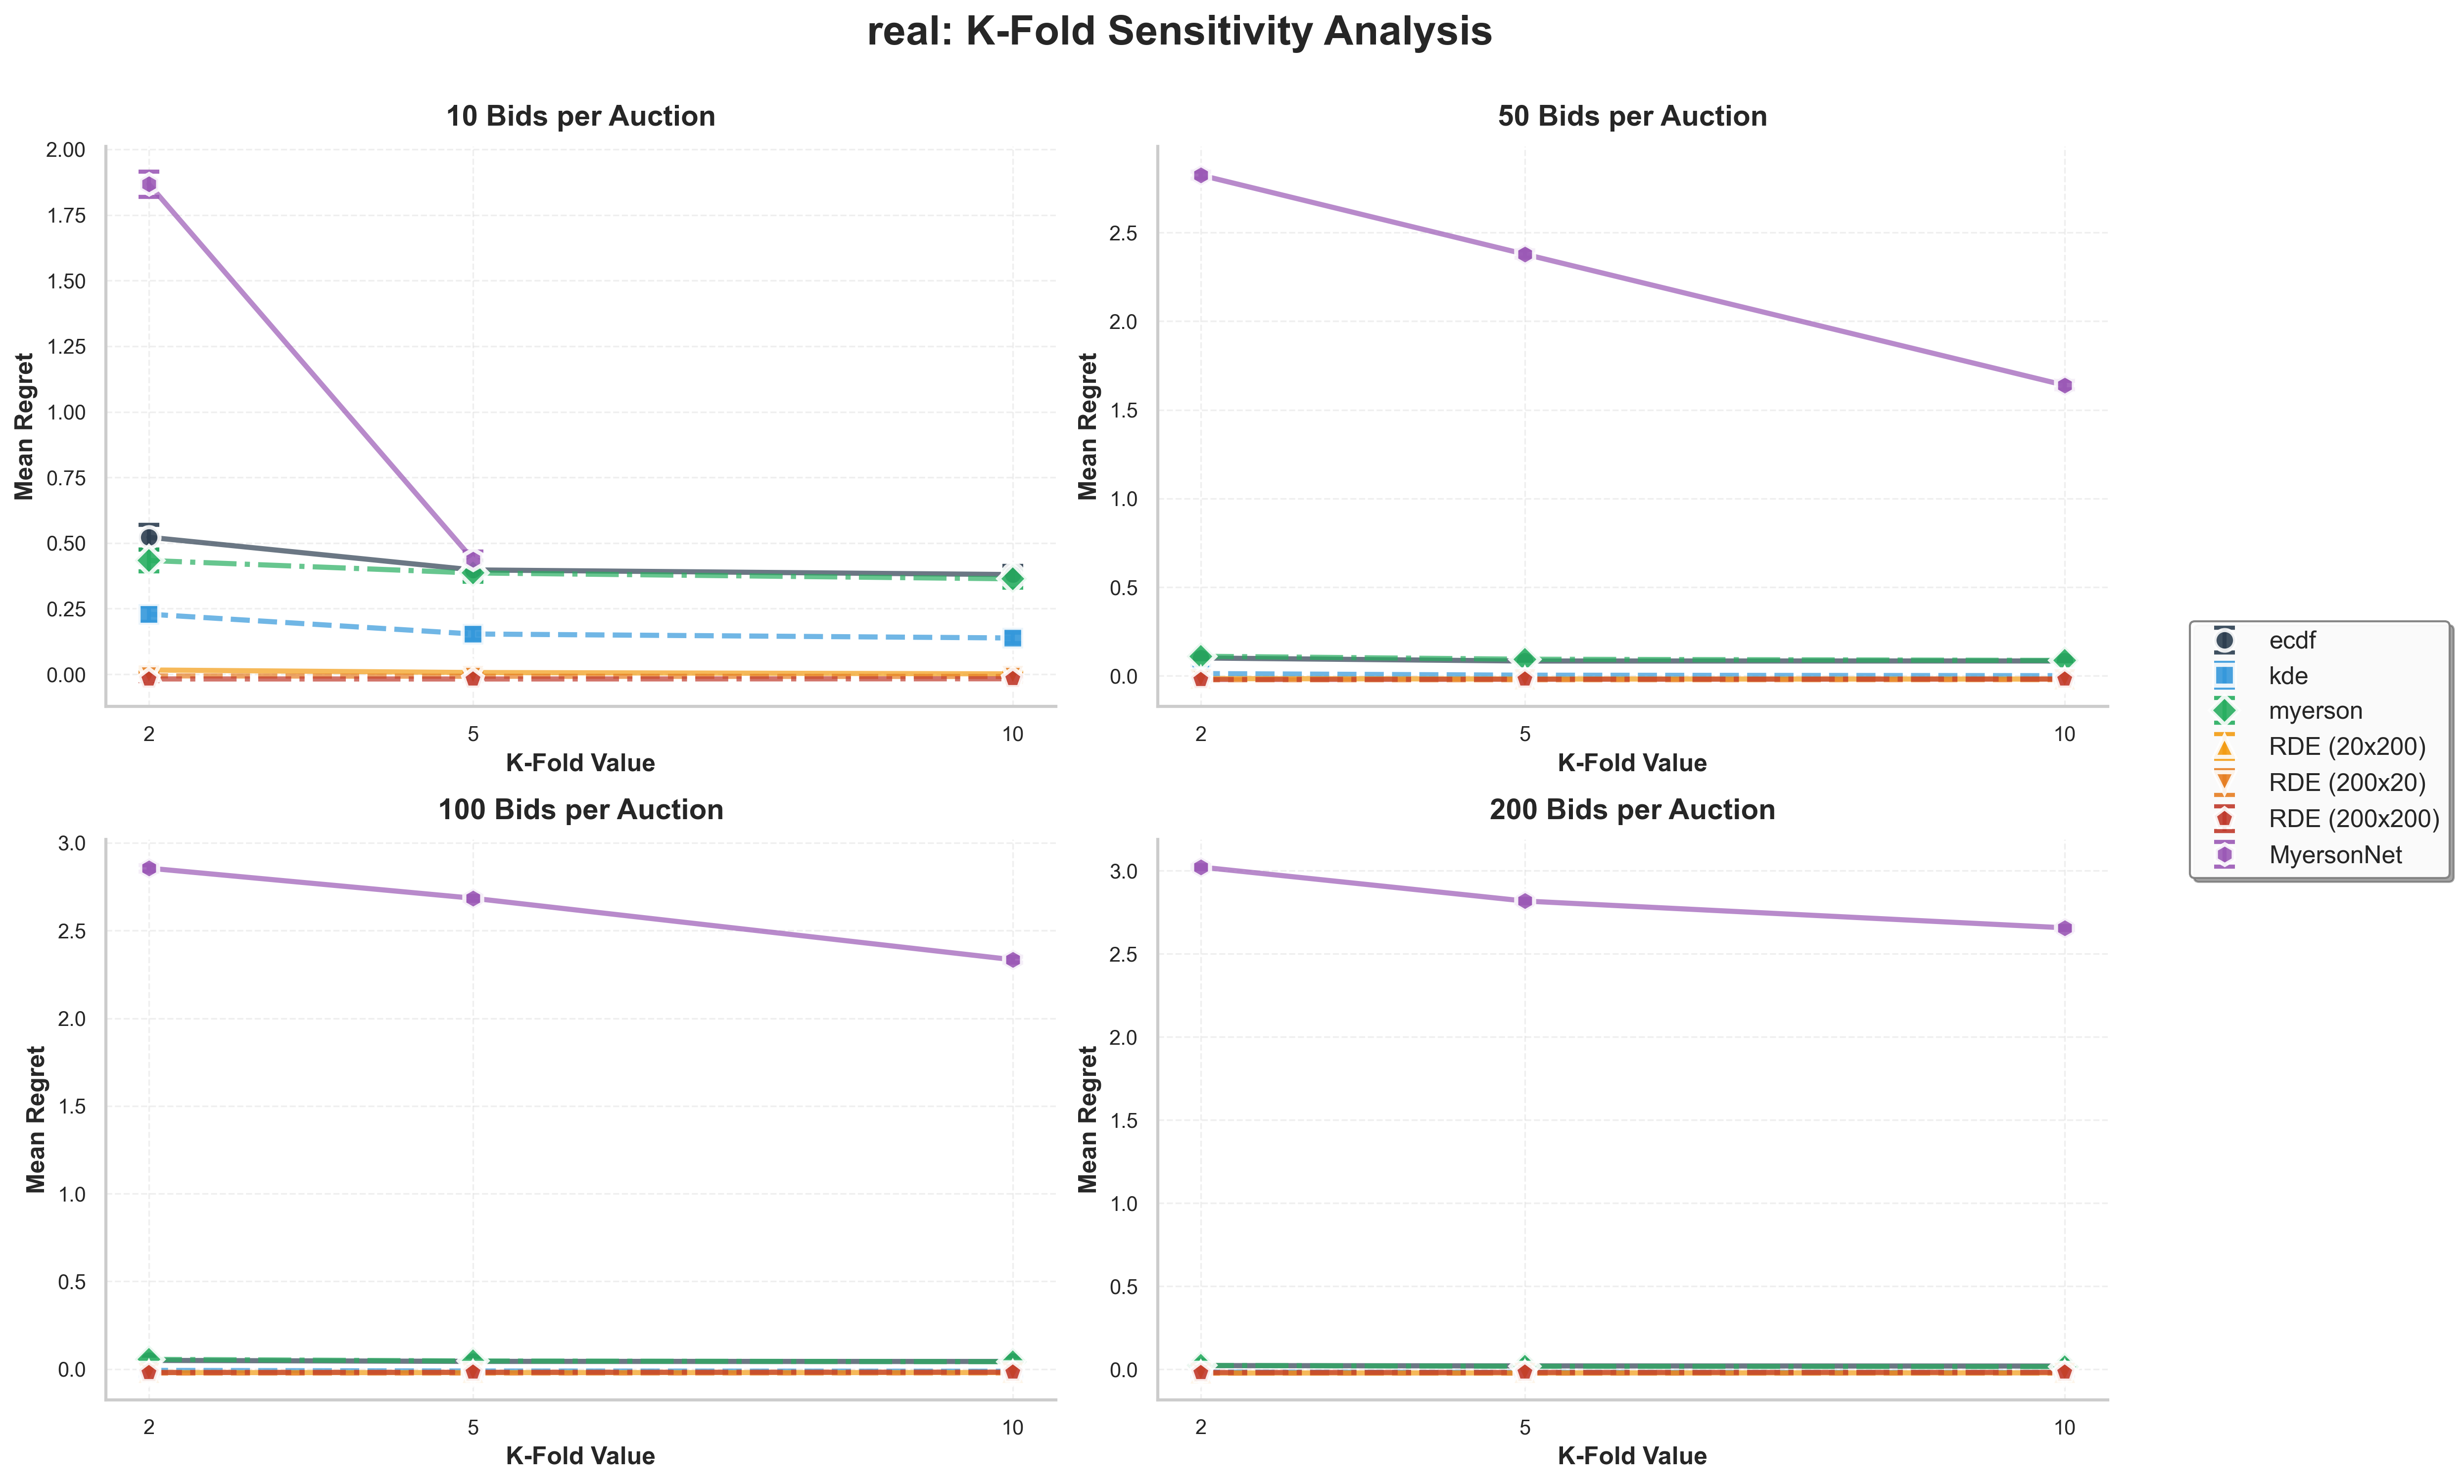

In [19]:
plot_kfold_sensitivity(
    project_root=project_root,
    dist_names="real",
    bids_per_auction=BIDS_PER_AUCTION,
    k_folds=K_FOLDS,
    save_dir="workspace/plots/sensitivity",
    show=True,
)

✅ Saved: histogram_real_k2.png (4 subplots: 10, 50, 100, 200 bids)


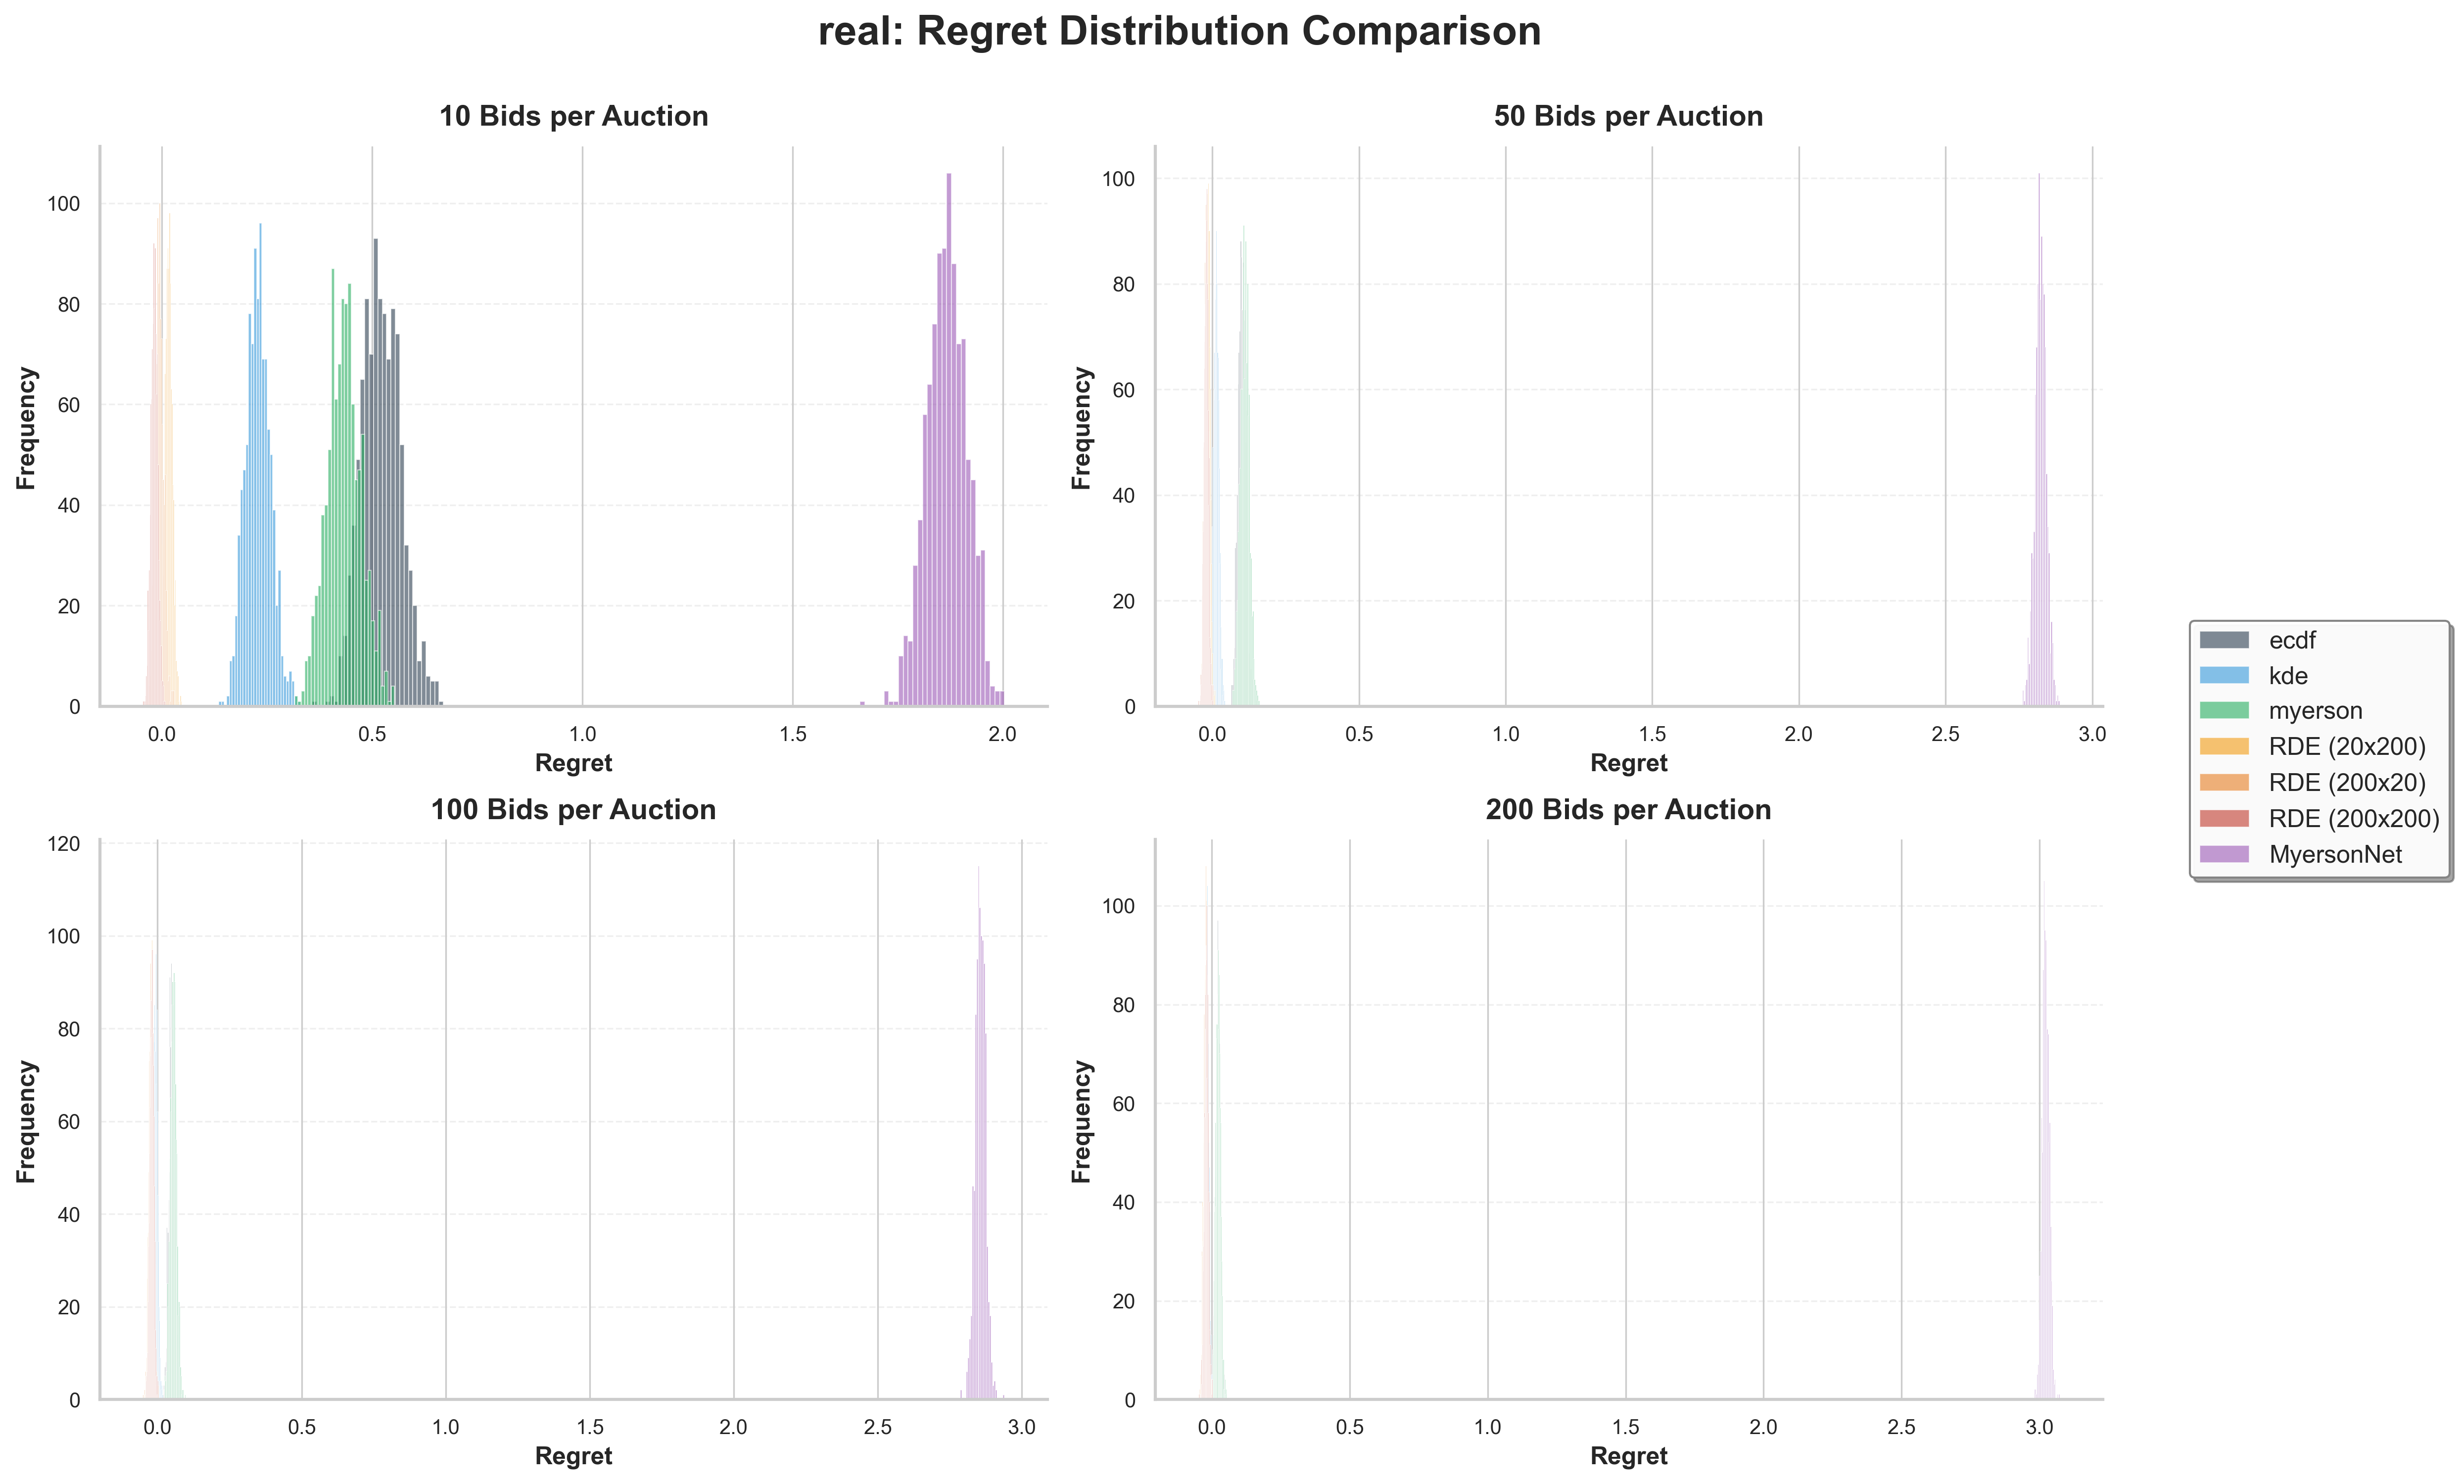

In [20]:
plot_regret_histograms(
    project_root=project_root,
    dist_names="real",
    bids_per_auction=BIDS_PER_AUCTION,  # [10, 50, 100, 200]
    k_fold=2,  # Use K=2 for histogram comparison
    save_dir="workspace/plots/histograms",
    show=True,
)

In [21]:
METHODS_WITHOUT_MYERSONNET = [
    "ecdf",
    "kde",
    "myerson",
    "RDE (20x200)",
    "RDE (200x20)",
    "RDE (200x200)",
]

✅ Saved: kfold_sensitivity_real_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


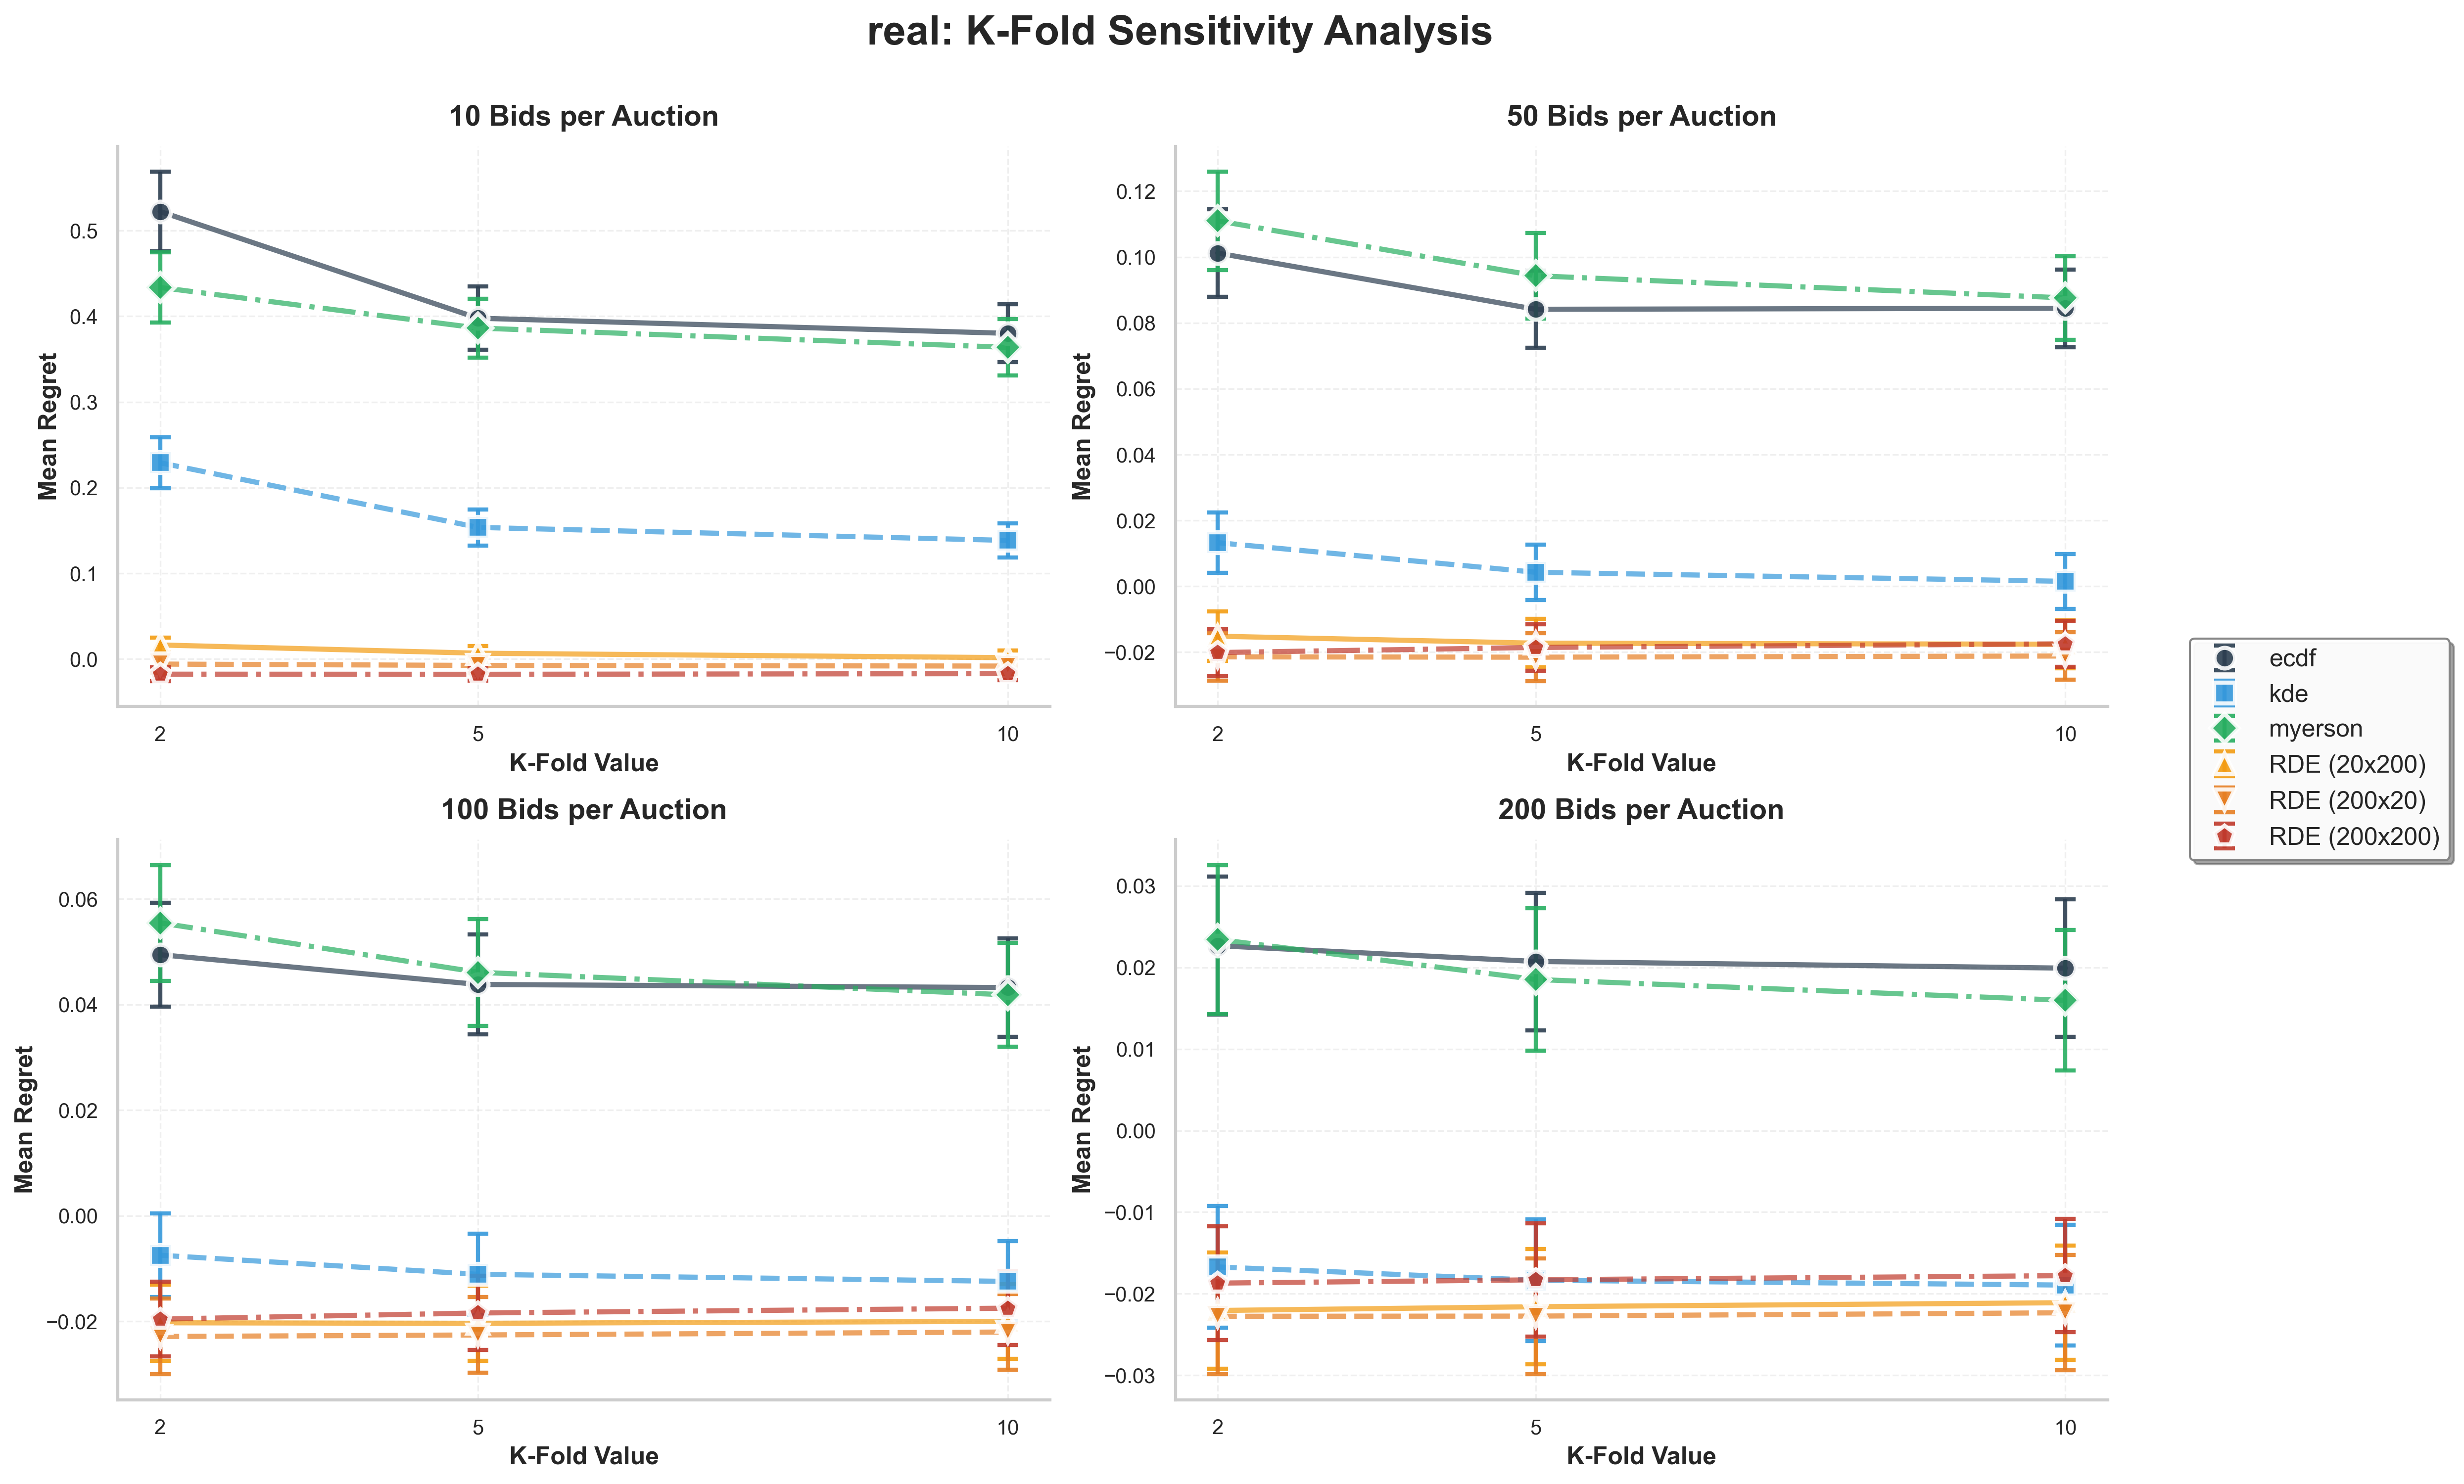

In [22]:
plot_kfold_sensitivity(
    project_root=project_root,
    dist_names="real",
    bids_per_auction=BIDS_PER_AUCTION,
    k_folds=K_FOLDS,
    methods=METHODS_WITHOUT_MYERSONNET,
    save_dir="workspace/plots/sensitivity",
    show=True,
    suffix="no_myersonnet",
)

✅ Saved: histogram_real_k2_no_myersonnet.png (4 subplots: 10, 50, 100, 200 bids)


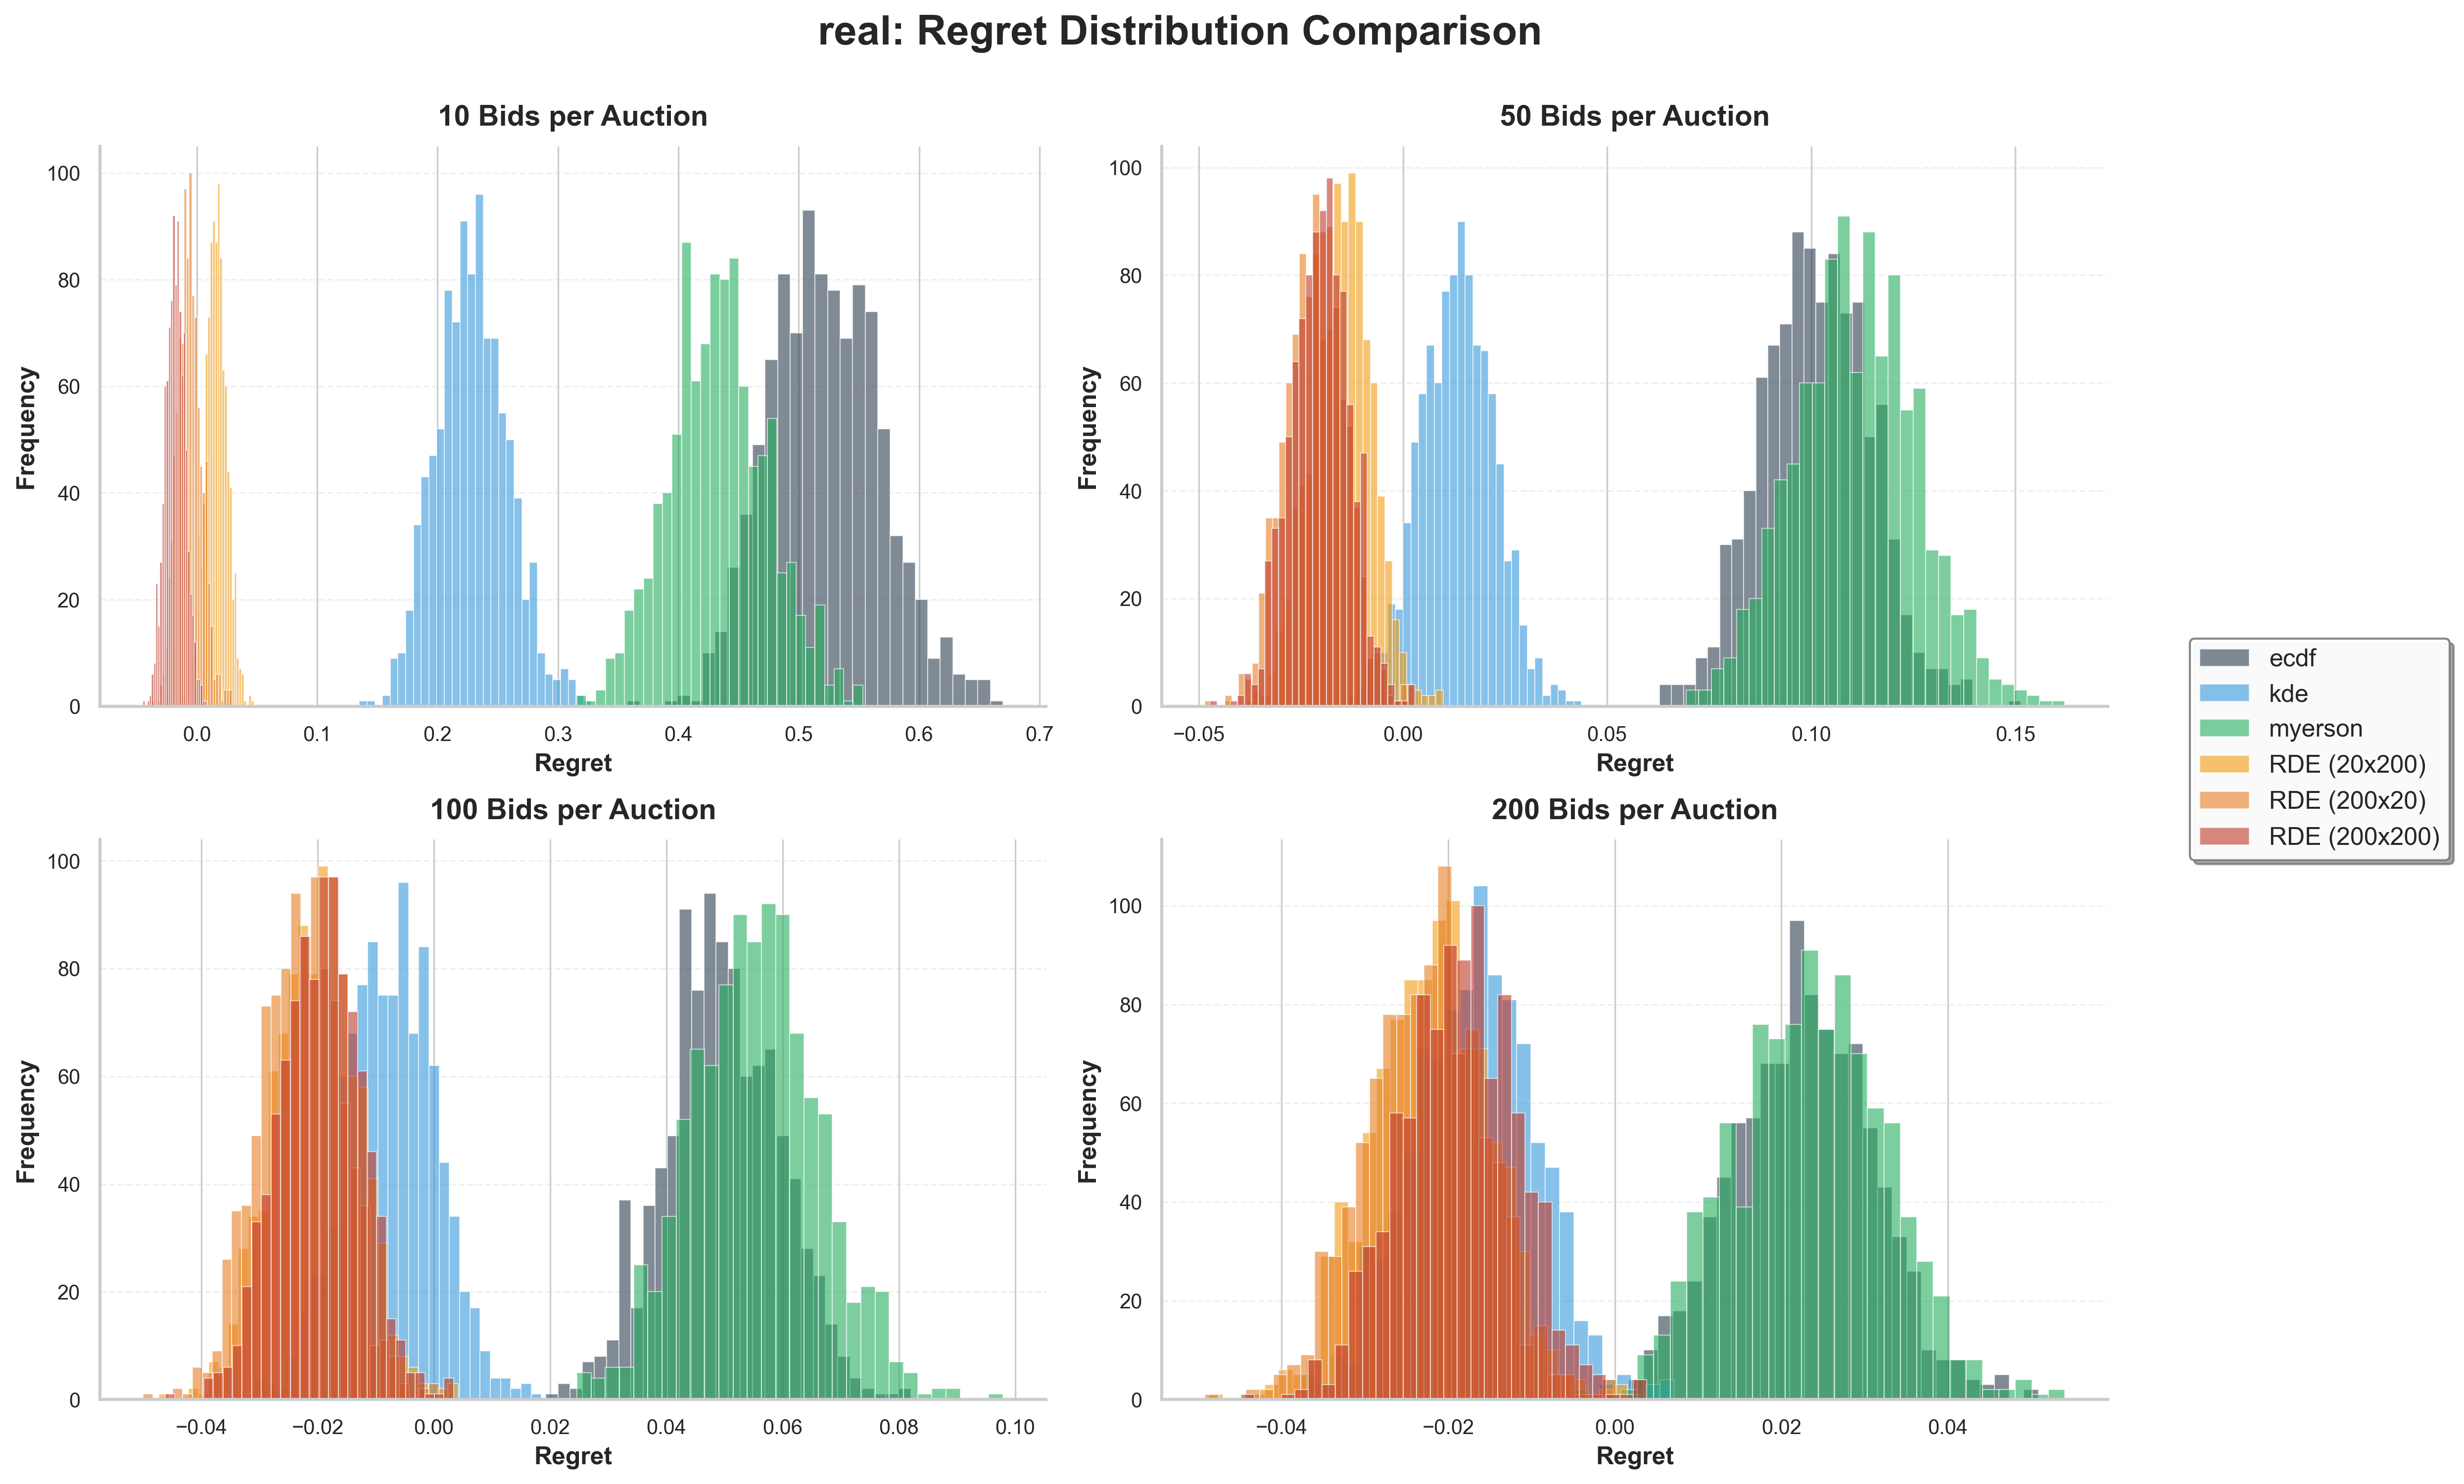

In [23]:
plot_regret_histograms(
    project_root=project_root,
    dist_names="real",
    bids_per_auction=BIDS_PER_AUCTION,  # [10, 50, 100, 200]
    k_fold=2,  # Use K=2 for histogram comparison
    methods=METHODS_WITHOUT_MYERSONNET,
    save_dir="workspace/plots/histograms",
    show=True,
    suffix="no_myersonnet",
)